In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import scvelo as scv
import scipy as sp
from scipy import special
from scipy.stats import poisson,norm
from scipy.special import j_roots
from scipy.special import beta as beta_fun 
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#!pip install scvelo

%ls

# Load the dataframe to select genes

In [3]:
df = pd.read_csv("data/std_data.csv", sep=';')
df['ensembl_id']=df['Unnamed: 0']
del df['Unnamed: 0']
df

,allele_1_sum,allele_1_mean,allele_2_sum,allele_2_mean,std,ensembl_id
0,321.291178,0.471101,360.708822,0.528899,0.157535,ENSMUSG00000000001
1,29.500000,0.460938,34.500000,0.539062,0.498447,ENSMUSG00000000049
2,350.605317,0.514084,331.394683,0.485916,0.151797,ENSMUSG00000000088
3,0.000000,0.000000,3.000000,1.000000,0.000000,ENSMUSG00000000120
4,357.947744,0.524850,324.052256,0.475150,0.144606,ENSMUSG00000000184
...,...,...,...,...,...,...
3129,2.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000100620
3130,2.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000103811
3131,4.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000112500
3132,2.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000114922


# Add gene names

In [4]:
# load GRCm38.91 (mm10) from Ensembl
# couldn't find the exact version of the gtf file. The closest was release 102 instead of 91 
# https://nov2020.archive.ensembl.org/Mus_musculus/Info/Index
# Mus_musculus.GRCm38.102.chr.gtf.gz
#!gzip -d Mus_musculus.GRCm38.102.chr.gtf.gz


gtf = pd.read_csv("data/Mus_musculus.GRCm38.102.chr.gtf", sep='\t', skiprows=5, header=None)
gtf.columns = ['chr', 'database', 'type', 'start', 'end', '.', 'strand', '.', 'other']
gtf = gtf[gtf['type'] == "gene"]
gtf = gtf.reset_index()
gtf

,index,chr,database,type,start,end,.,strand,.,other
0,0,1,havana,gene,3073253,3074322,.,+,.,"gene_id ""ENSMUSG00000102693""; gene_version ""1""..."
1,3,1,ensembl,gene,3102016,3102125,.,+,.,"gene_id ""ENSMUSG00000064842""; gene_version ""1""..."
2,6,1,ensembl_havana,gene,3205901,3671498,.,-,.,"gene_id ""ENSMUSG00000051951""; gene_version ""5""..."
3,24,1,havana,gene,3252757,3253236,.,+,.,"gene_id ""ENSMUSG00000102851""; gene_version ""1""..."
4,27,1,havana,gene,3365731,3368549,.,-,.,"gene_id ""ENSMUSG00000103377""; gene_version ""1""..."
...,...,...,...,...,...,...,...,...,...,...
55396,1868643,MT,insdc,gene,13552,14070,.,-,.,"gene_id ""ENSMUSG00000064368""; gene_version ""1""..."
55397,1868649,MT,insdc,gene,14071,14139,.,-,.,"gene_id ""ENSMUSG00000064369""; gene_version ""1""..."
55398,1868652,MT,insdc,gene,14145,15288,.,+,.,"gene_id ""ENSMUSG00000064370""; gene_version ""1""..."
55399,1868657,MT,insdc,gene,15289,15355,.,+,.,"gene_id ""ENSMUSG00000064371""; gene_version ""1""..."


In [5]:
dic_gene_names = {}
index = 0
for line in gtf['other'].tolist():
    line = line.split(';')
    dic_gene_names[line[0][9:-1]]= [gtf['chr'][index], line[2][12:-1]]
    index += 1
#dic_gene_names

In [6]:
df['gene_name'] = [dic_gene_names[x][1] if x in dic_gene_names.keys() else 'NA' for x in df['ensembl_id']]
df['chromosome'] = [dic_gene_names[x][0] if x in dic_gene_names.keys() else 'NA' for x in df['ensembl_id']]
df

,allele_1_sum,allele_1_mean,allele_2_sum,allele_2_mean,std,ensembl_id,gene_name,chromosome
0,321.291178,0.471101,360.708822,0.528899,0.157535,ENSMUSG00000000001,Gnai3,3
1,29.500000,0.460938,34.500000,0.539062,0.498447,ENSMUSG00000000049,Apoh,11
2,350.605317,0.514084,331.394683,0.485916,0.151797,ENSMUSG00000000088,Cox5a,9
3,0.000000,0.000000,3.000000,1.000000,0.000000,ENSMUSG00000000120,Ngfr,11
4,357.947744,0.524850,324.052256,0.475150,0.144606,ENSMUSG00000000184,Ccnd2,6
...,...,...,...,...,...,...,...,...
3129,2.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000100620,Gm28277,1
3130,2.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000103811,Gm38004,9
3131,4.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000112500,4933411E08Rik,10
3132,2.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000114922,Ppifos,14


In [7]:
label = []
for chrom in df['chromosome']:
    if chrom == "X":
        label.append('X')
    elif chrom == "Y":
        label.append('Y')
    else:
        label.append('autosome')
df['autosomes'] = label

In [8]:
label = []
for chrom in df['chromosome']:
    if chrom == "MT":
        label.append('MT')
    else:
        label.append('nuclear')
df['nuclear'] = label

# Load the corresponding Anndata


In [10]:
adata=ad.read('data/with_ratio.h5ad')
adata

AnnData object with n_obs × n_vars = 682 × 1953
    obs: 'leiden', 'clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_dynamical_genes', 'rank_genes_groups', 'recover_dynamics', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

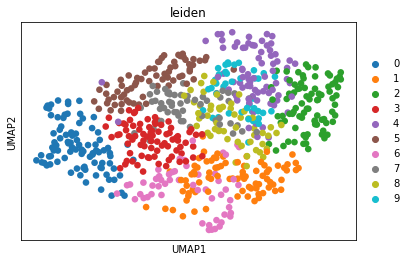

In [11]:
sc.pl.umap(adata, color='leiden')

# Start exploring the data

<AxesSubplot:xlabel='std', ylabel='allele_1_sum'>

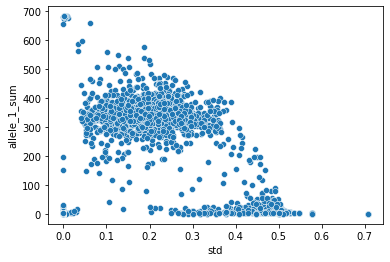

In [12]:
sns.scatterplot(data=df, x="std", y="allele_1_sum")

<AxesSubplot:xlabel='std', ylabel='allele_1_mean'>

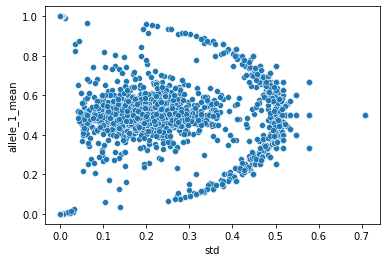

In [13]:
sns.scatterplot(data=df, x="std", y="allele_1_mean")

### Try some filtering of interesting genes

In [14]:
#df[df.allele_1_mean > 0.5]
df[(df.allele_2_mean > 0.5) & (df["std"] > 0.5 )]

,allele_1_sum,allele_1_mean,allele_2_sum,allele_2_mean,std,ensembl_id,gene_name,chromosome,autosomes,nuclear
6,1.000000,0.333333,2.000000,0.666667,0.577350,ENSMUSG00000000303,Cdh1,8,autosome,nuclear
243,2.000000,0.400000,3.000000,0.600000,0.547723,ENSMUSG00000011118,Panx3,9,autosome,nuclear
281,1.000000,0.333333,2.000000,0.666667,0.577350,ENSMUSG00000015437,Gzmb,14,autosome,nuclear
396,10.833333,0.492424,11.166667,0.507576,0.505204,ENSMUSG00000019987,Arg1,10,autosome,nuclear
448,8.000000,0.400000,12.000000,0.600000,0.502625,ENSMUSG00000020419,Hormad2,11,autosome,nuclear
...,...,...,...,...,...,...,...,...,...,...
2976,1.000000,0.333333,2.000000,0.666667,0.577350,ENSMUSG00000086396,4930555B11Rik,2,autosome,nuclear
2979,1.000000,0.333333,2.000000,0.666667,0.577350,ENSMUSG00000088549,Gm24959,18,autosome,nuclear
2990,1.000000,0.333333,2.000000,0.666667,0.577350,ENSMUSG00000105368,Gm43759,5,autosome,nuclear
2992,1.000000,0.333333,2.000000,0.666667,0.577350,ENSMUSG00000105469,A930036I15Rik,3,autosome,nuclear


In [15]:
df['color'] = ['Green' for x in df.index.tolist()]
df.loc[(df.allele_2_mean > 0.5) & (df["std"] > 0.5 ), 'color'] = 'Red'
df

,allele_1_sum,allele_1_mean,allele_2_sum,allele_2_mean,std,ensembl_id,gene_name,chromosome,autosomes,nuclear,color
0,321.291178,0.471101,360.708822,0.528899,0.157535,ENSMUSG00000000001,Gnai3,3,autosome,nuclear,Green
1,29.500000,0.460938,34.500000,0.539062,0.498447,ENSMUSG00000000049,Apoh,11,autosome,nuclear,Green
2,350.605317,0.514084,331.394683,0.485916,0.151797,ENSMUSG00000000088,Cox5a,9,autosome,nuclear,Green
3,0.000000,0.000000,3.000000,1.000000,0.000000,ENSMUSG00000000120,Ngfr,11,autosome,nuclear,Green
4,357.947744,0.524850,324.052256,0.475150,0.144606,ENSMUSG00000000184,Ccnd2,6,autosome,nuclear,Green
...,...,...,...,...,...,...,...,...,...,...,...
3129,2.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000100620,Gm28277,1,autosome,nuclear,Green
3130,2.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000103811,Gm38004,9,autosome,nuclear,Green
3131,4.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000112500,4933411E08Rik,10,autosome,nuclear,Green
3132,2.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000114922,Ppifos,14,autosome,nuclear,Green


<AxesSubplot:xlabel='std', ylabel='allele_1_mean'>

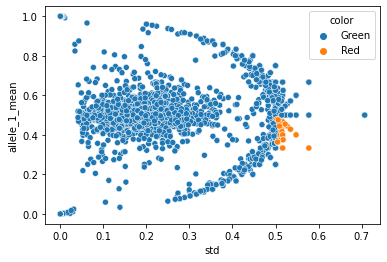

In [16]:
sns.scatterplot(data=df, x="std", y="allele_1_mean", hue="color")

<AxesSubplot:xlabel='std', ylabel='allele_1_mean'>

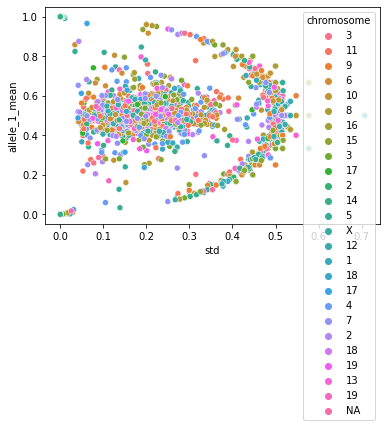

In [17]:
sns.scatterplot(data=df, x="std", y="allele_1_mean", hue="chromosome")

<AxesSubplot:xlabel='std', ylabel='allele_1_mean'>

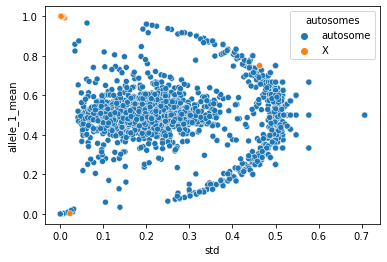

In [18]:
df = df.sort_values('autosomes', ascending=False)
sns.scatterplot(data=df, x="std", y="allele_1_mean", hue="autosomes")

In [19]:
pd.crosstab(df['autosomes'], df['chromosome'])

chromosome,1,2,3,4,5,6,7,8,9,10,...,17,18,19,17,18,19,2,3,NA,X
autosomes,,,,,,,,,,,,,,,,,,,,,
X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,63
autosome,196,192,63,192,232,175,244,179,178,173,...,48,51,56,52,13,45,12,110,24,0


In [20]:
df2 = df[df['autosomes'] == 'X']
df2

,allele_1_sum,allele_1_mean,allele_2_sum,allele_2_mean,std,ensembl_id,gene_name,chromosome,autosomes,nuclear,color
3094,4.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000103436,Gm36995,X,X,nuclear,Green
2092,196.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000065422,Mir221,X,X,nuclear,Green
1312,681.784204,0.999684,0.215796,0.000316,0.003379,ENSMUSG00000031402,Mpp1,X,X,nuclear,Green
33,681.885100,0.999832,0.114900,0.000168,0.001135,ENSMUSG00000001131,Timp1,X,X,nuclear,Green
3117,2.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000031101,Sash3,X,X,nuclear,Green
...,...,...,...,...,...,...,...,...,...,...,...
60,681.676369,0.999525,0.323631,0.000475,0.003870,ENSMUSG00000001924,Uba1,X,X,nuclear,Green
1297,681.569729,0.999369,0.430271,0.000631,0.004852,ENSMUSG00000031059,Ndufb11,X,X,nuclear,Green
63,681.958333,0.999939,0.041667,0.000061,0.001595,ENSMUSG00000002010,Idh3g,X,X,nuclear,Green
64,681.629015,0.999456,0.370985,0.000544,0.002915,ENSMUSG00000002015,Bcap31,X,X,nuclear,Green


<AxesSubplot:xlabel='std', ylabel='Density'>

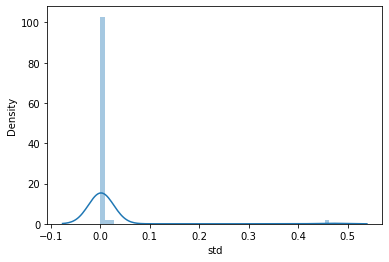

In [21]:
sns.distplot(df2['std'])

<AxesSubplot:xlabel='allele_1_mean', ylabel='Density'>

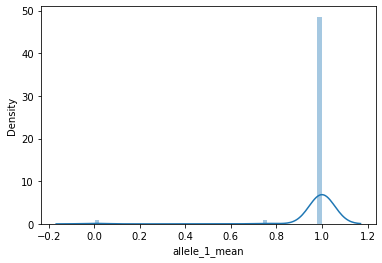

In [22]:
sns.distplot(df2['allele_1_mean'])

<AxesSubplot:xlabel='allele_2_mean', ylabel='Density'>

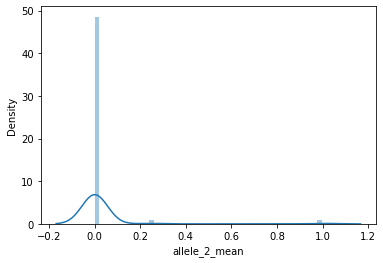

In [23]:
sns.distplot(df2['allele_2_mean'])

<AxesSubplot:xlabel='std', ylabel='allele_1_mean'>

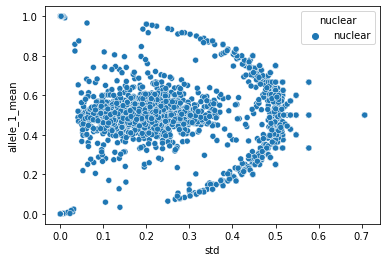

In [24]:
sns.scatterplot(data=df, x="std", y="allele_1_mean", hue="nuclear")

### Looking at Ribosomal Proteins

In [25]:
df

,allele_1_sum,allele_1_mean,allele_2_sum,allele_2_mean,std,ensembl_id,gene_name,chromosome,autosomes,nuclear,color
0,321.291178,0.471101,360.708822,0.528899,0.157535,ENSMUSG00000000001,Gnai3,3,autosome,nuclear,Green
2042,359.533814,0.531855,316.466186,0.468145,0.281422,ENSMUSG00000062908,Acadm,3,autosome,nuclear,Green
2068,297.826969,0.443195,374.173031,0.556805,0.279471,ENSMUSG00000064037,Gpn1,5,autosome,nuclear,Green
2069,453.225012,0.664553,228.774988,0.335447,0.081472,ENSMUSG00000064080,Fbln2,6,autosome,nuclear,Green
2070,449.024952,0.658394,232.975048,0.341606,0.222706,ENSMUSG00000064210,Ano6,15,autosome,nuclear,Green
...,...,...,...,...,...,...,...,...,...,...,...
60,681.676369,0.999525,0.323631,0.000475,0.003870,ENSMUSG00000001924,Uba1,X,X,nuclear,Green
1297,681.569729,0.999369,0.430271,0.000631,0.004852,ENSMUSG00000031059,Ndufb11,X,X,nuclear,Green
63,681.958333,0.999939,0.041667,0.000061,0.001595,ENSMUSG00000002010,Idh3g,X,X,nuclear,Green
64,681.629015,0.999456,0.370985,0.000544,0.002915,ENSMUSG00000002015,Bcap31,X,X,nuclear,Green


In [26]:
label = []
for genes in df.gene_name:
    if genes[:2]=='Rp':
        label.append('Ribosomal protein')
    else:
        label.append('other protein')
df['Ribosomal_prot'] = label

In [27]:
df

,allele_1_sum,allele_1_mean,allele_2_sum,allele_2_mean,std,ensembl_id,gene_name,chromosome,autosomes,nuclear,color,Ribosomal_prot
0,321.291178,0.471101,360.708822,0.528899,0.157535,ENSMUSG00000000001,Gnai3,3,autosome,nuclear,Green,other protein
2042,359.533814,0.531855,316.466186,0.468145,0.281422,ENSMUSG00000062908,Acadm,3,autosome,nuclear,Green,other protein
2068,297.826969,0.443195,374.173031,0.556805,0.279471,ENSMUSG00000064037,Gpn1,5,autosome,nuclear,Green,other protein
2069,453.225012,0.664553,228.774988,0.335447,0.081472,ENSMUSG00000064080,Fbln2,6,autosome,nuclear,Green,other protein
2070,449.024952,0.658394,232.975048,0.341606,0.222706,ENSMUSG00000064210,Ano6,15,autosome,nuclear,Green,other protein
...,...,...,...,...,...,...,...,...,...,...,...,...
60,681.676369,0.999525,0.323631,0.000475,0.003870,ENSMUSG00000001924,Uba1,X,X,nuclear,Green,other protein
1297,681.569729,0.999369,0.430271,0.000631,0.004852,ENSMUSG00000031059,Ndufb11,X,X,nuclear,Green,other protein
63,681.958333,0.999939,0.041667,0.000061,0.001595,ENSMUSG00000002010,Idh3g,X,X,nuclear,Green,other protein
64,681.629015,0.999456,0.370985,0.000544,0.002915,ENSMUSG00000002015,Bcap31,X,X,nuclear,Green,other protein


<AxesSubplot:xlabel='std', ylabel='allele_1_mean'>

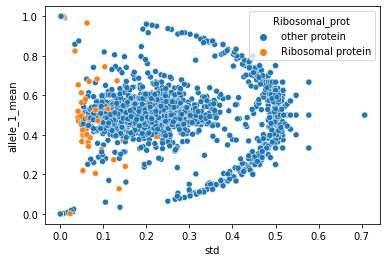

In [28]:
sns.scatterplot(data=df, x="std", y="allele_1_mean", hue="Ribosomal_prot")

<AxesSubplot:xlabel='std', ylabel='allele_1_sum'>

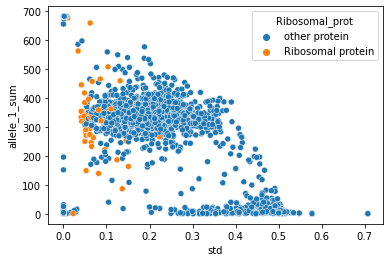

In [29]:
sns.scatterplot(data=df, x="std", y="allele_1_sum", hue="Ribosomal_prot")

<AxesSubplot:xlabel='std', ylabel='allele_2_sum'>

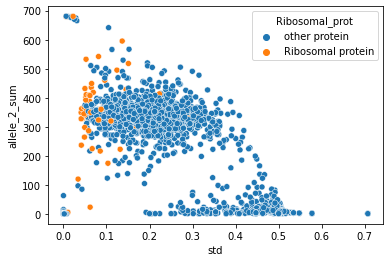

In [30]:
sns.scatterplot(data=df, x="std", y="allele_2_sum", hue="Ribosomal_prot")

## Try to identify better genes

In [31]:
#df[df.allele_1_mean > 0.5]
df[((df.allele_2_sum > 600) & (df["std"] < 0.1 )) | ((df.allele_1_sum > 600) & (df["std"] < 0.1 ))]

,allele_1_sum,allele_1_mean,allele_2_sum,allele_2_mean,std,ensembl_id,gene_name,chromosome,autosomes,nuclear,color,Ribosomal_prot
1978,7.099890,0.010410,674.900110,0.989590,0.028806,ENSMUSG00000059159,Gm8129,6,autosome,nuclear,Green,other protein
2004,2.601160,0.003814,679.398840,0.996186,0.011134,ENSMUSG00000060680,Gm8894,14,autosome,nuclear,Green,other protein
2273,3.255926,0.004774,678.744074,0.995226,0.017993,ENSMUSG00000080776,Gm12174,11,autosome,nuclear,Green,other protein
2278,2.346981,0.003441,679.653019,0.996559,0.005929,ENSMUSG00000081094,Rpl19-ps11,8,autosome,nuclear,Green,Ribosomal protein
2281,16.613200,0.024360,665.386800,0.975640,0.031020,ENSMUSG00000081239,Gm11836,4,autosome,nuclear,Green,other protein
1758,658.677006,0.965802,23.322994,0.034198,0.061960,ENSMUSG00000044533,Rps2,17,autosome,nuclear,Green,Ribosomal protein
2501,5.196106,0.007619,676.803894,0.992381,0.017123,ENSMUSG00000094530,Gm21399,8,autosome,nuclear,Green,other protein
2656,1.230544,0.001804,680.769456,0.998196,0.006208,ENSMUSG00000104623,Gm6394,3,autosome,nuclear,Green,other protein
2558,11.722937,0.017189,670.277063,0.982811,0.025212,ENSMUSG00000098178,NA,NA,autosome,nuclear,Green,other protein
1312,681.784204,0.999684,0.215796,0.000316,0.003379,ENSMUSG00000031402,Mpp1,X,X,nuclear,Green,other protein


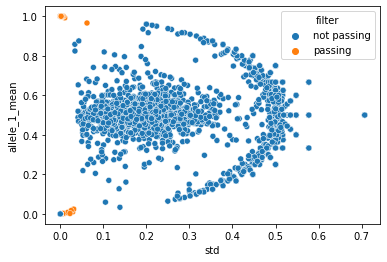

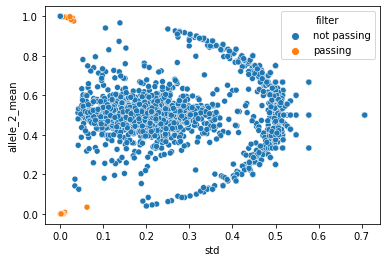

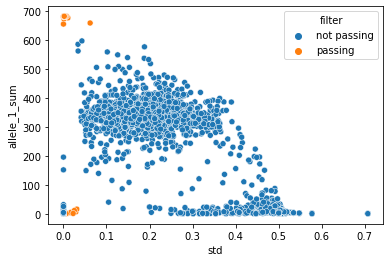

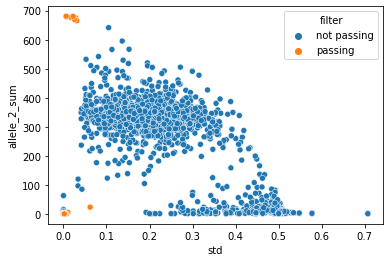

In [32]:
df['filter'] = ['not passing' for x in df.index.tolist()]
df.loc[((df.allele_2_sum > 600) & (df["std"] < 0.1 )) | ((df.allele_1_sum > 600) & (df["std"] < 0.1 )), 'filter'] = 'passing'
sns.scatterplot(data=df, x="std", y="allele_1_mean", hue="filter")
plt.show()
sns.scatterplot(data=df, x="std", y="allele_2_mean", hue="filter")
plt.show()
sns.scatterplot(data=df, x="std", y="allele_1_sum", hue="filter")
plt.show()
sns.scatterplot(data=df, x="std", y="allele_2_sum", hue="filter")
plt.show()

In [33]:
scv.pl.scatter?

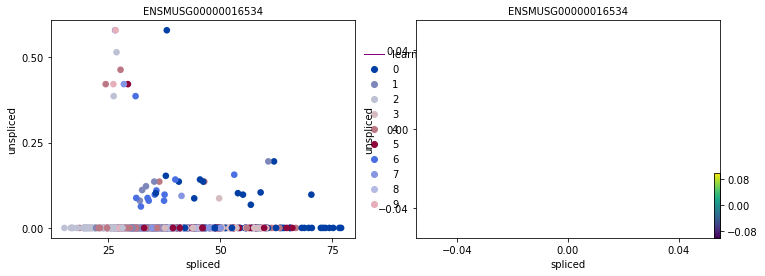

In [34]:
# Lamp2
scv.pl.scatter(adata, 'ENSMUSG00000016534', color=['clusters', 'velocity'], legend_loc='right margin')

In [35]:
df2 = df2.reset_index()
df2

,index,allele_1_sum,allele_1_mean,allele_2_sum,allele_2_mean,std,ensembl_id,gene_name,chromosome,autosomes,nuclear,color
0,3094,4.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000103436,Gm36995,X,X,nuclear,Green
1,2092,196.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000065422,Mir221,X,X,nuclear,Green
2,1312,681.784204,0.999684,0.215796,0.000316,0.003379,ENSMUSG00000031402,Mpp1,X,X,nuclear,Green
3,33,681.885100,0.999832,0.114900,0.000168,0.001135,ENSMUSG00000001131,Timp1,X,X,nuclear,Green
4,3117,2.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000031101,Sash3,X,X,nuclear,Green
...,...,...,...,...,...,...,...,...,...,...,...,...
58,60,681.676369,0.999525,0.323631,0.000475,0.003870,ENSMUSG00000001924,Uba1,X,X,nuclear,Green
59,1297,681.569729,0.999369,0.430271,0.000631,0.004852,ENSMUSG00000031059,Ndufb11,X,X,nuclear,Green
60,63,681.958333,0.999939,0.041667,0.000061,0.001595,ENSMUSG00000002010,Idh3g,X,X,nuclear,Green
61,64,681.629015,0.999456,0.370985,0.000544,0.002915,ENSMUSG00000002015,Bcap31,X,X,nuclear,Green


In [36]:
adata.var_names

Index(['ENSMUSG00000000001', 'ENSMUSG00000000049', 'ENSMUSG00000000088',
       'ENSMUSG00000000184', 'ENSMUSG00000000295', 'ENSMUSG00000000326',
       'ENSMUSG00000000339', 'ENSMUSG00000000346', 'ENSMUSG00000000378',
       'ENSMUSG00000000563',
       ...
       'ENSMUSG00000113902', 'ENSMUSG00000113909', 'ENSMUSG00000114104',
       'ENSMUSG00000114995', 'ENSMUSG00000115049', 'ENSMUSG00000115124',
       'ENSMUSG00000115759', 'ENSMUSG00000005952', 'ENSMUSG00000022057',
       'ENSMUSG00000040181'],
      dtype='object', length=1953)

In [37]:
df2

,index,allele_1_sum,allele_1_mean,allele_2_sum,allele_2_mean,std,ensembl_id,gene_name,chromosome,autosomes,nuclear,color
0,3094,4.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000103436,Gm36995,X,X,nuclear,Green
1,2092,196.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000065422,Mir221,X,X,nuclear,Green
2,1312,681.784204,0.999684,0.215796,0.000316,0.003379,ENSMUSG00000031402,Mpp1,X,X,nuclear,Green
3,33,681.885100,0.999832,0.114900,0.000168,0.001135,ENSMUSG00000001131,Timp1,X,X,nuclear,Green
4,3117,2.000000,1.000000,0.000000,0.000000,0.000000,ENSMUSG00000031101,Sash3,X,X,nuclear,Green
...,...,...,...,...,...,...,...,...,...,...,...,...
58,60,681.676369,0.999525,0.323631,0.000475,0.003870,ENSMUSG00000001924,Uba1,X,X,nuclear,Green
59,1297,681.569729,0.999369,0.430271,0.000631,0.004852,ENSMUSG00000031059,Ndufb11,X,X,nuclear,Green
60,63,681.958333,0.999939,0.041667,0.000061,0.001595,ENSMUSG00000002010,Idh3g,X,X,nuclear,Green
61,64,681.629015,0.999456,0.370985,0.000544,0.002915,ENSMUSG00000002015,Bcap31,X,X,nuclear,Green


In [38]:
df3 = df[(df['std'] > 0.7)]
df3

,allele_1_sum,allele_1_mean,allele_2_sum,allele_2_mean,std,ensembl_id,gene_name,chromosome,autosomes,nuclear,color,Ribosomal_prot,filter
2083,1.0,0.5,1.0,0.5,0.707107,ENSMUSG00000064956,Gm24918,9,autosome,nuclear,Green,other protein,not passing
2085,1.0,0.5,1.0,0.5,0.707107,ENSMUSG00000064964,Gm25147,2,autosome,nuclear,Green,other protein,not passing
2128,1.0,0.5,1.0,0.5,0.707107,ENSMUSG00000068323,Slc4a5,6,autosome,nuclear,Green,other protein,not passing
2134,1.0,0.5,1.0,0.5,0.707107,ENSMUSG00000068614,Actc1,2,autosome,nuclear,Green,other protein,not passing
2097,1.0,0.5,1.0,0.5,0.707107,ENSMUSG00000065544,Mir32,4,autosome,nuclear,Green,other protein,not passing
...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,1.0,0.5,1.0,0.5,0.707107,ENSMUSG00000027196,Alkbh3os1,2,autosome,nuclear,Green,other protein,not passing
952,1.0,0.5,1.0,0.5,0.707107,ENSMUSG00000027048,Abcb11,2,autosome,nuclear,Green,other protein,not passing
1072,1.0,0.5,1.0,0.5,0.707107,ENSMUSG00000028626,Col9a2,4,autosome,nuclear,Green,other protein,not passing
1145,1.0,0.5,1.0,0.5,0.707107,ENSMUSG00000029269,Sult1b1,5,autosome,nuclear,Green,other protein,not passing


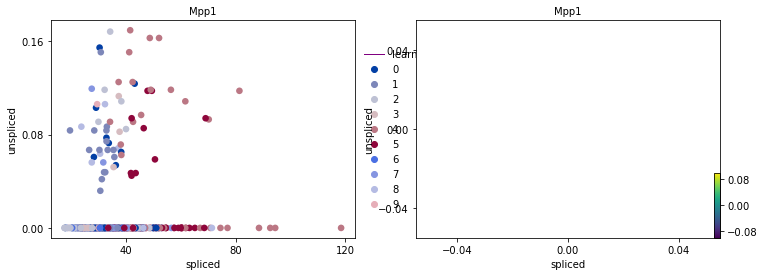

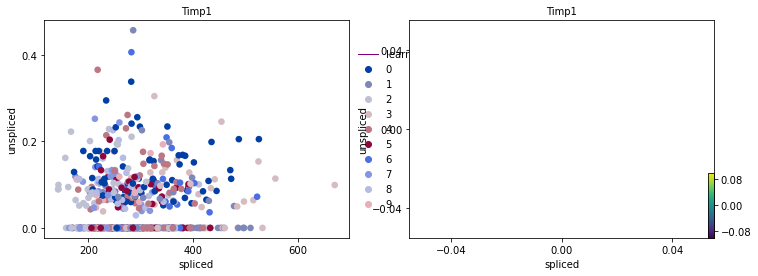

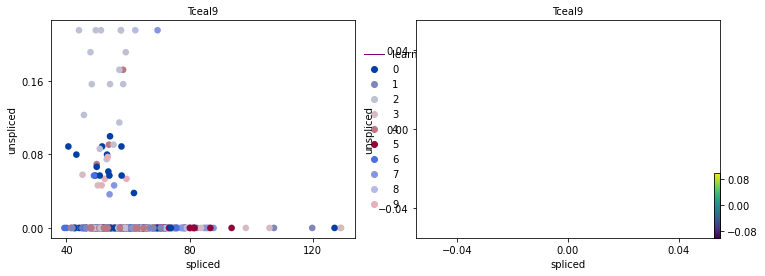

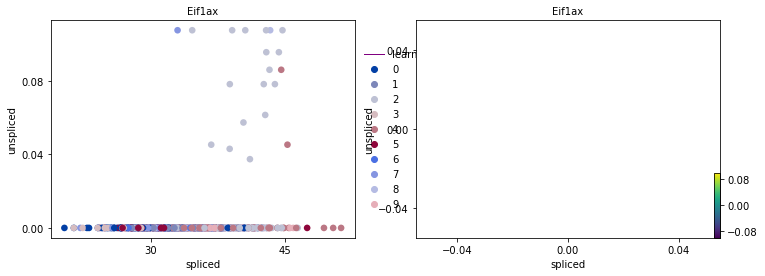

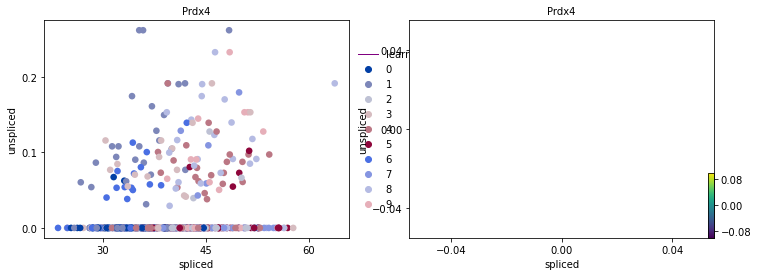

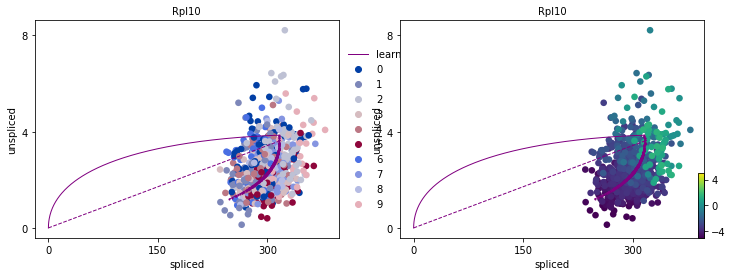

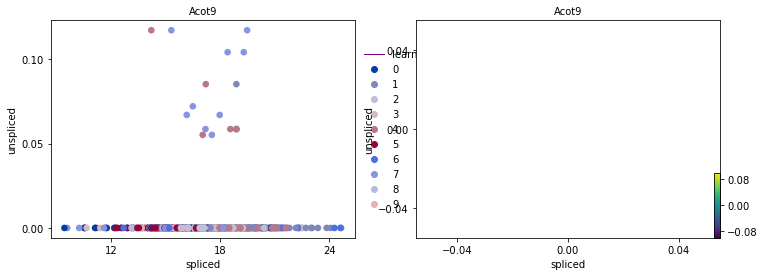

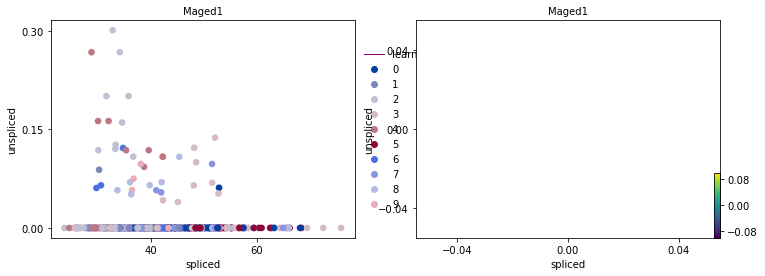

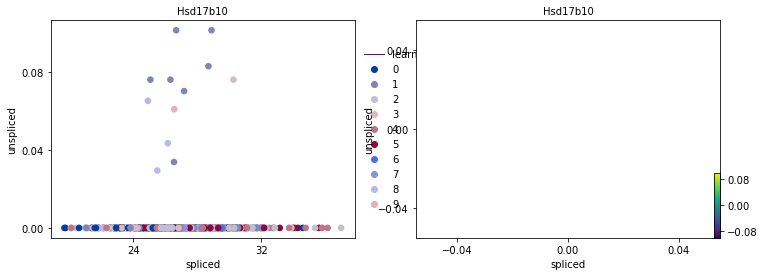

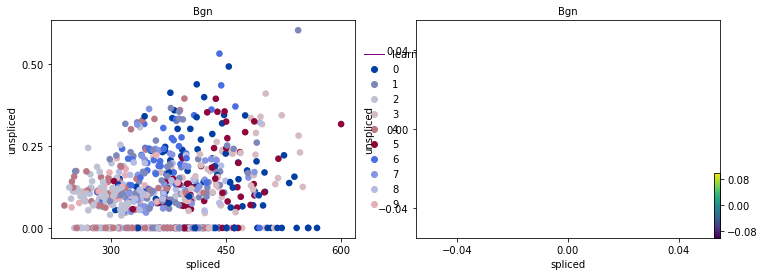

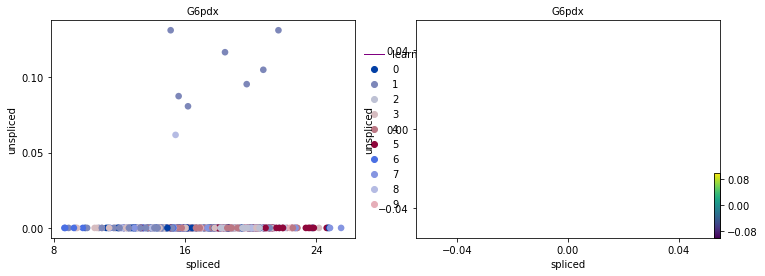

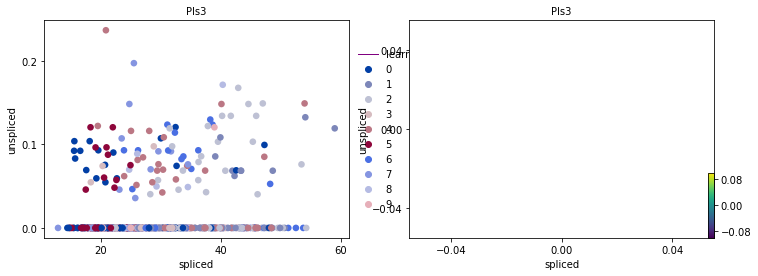

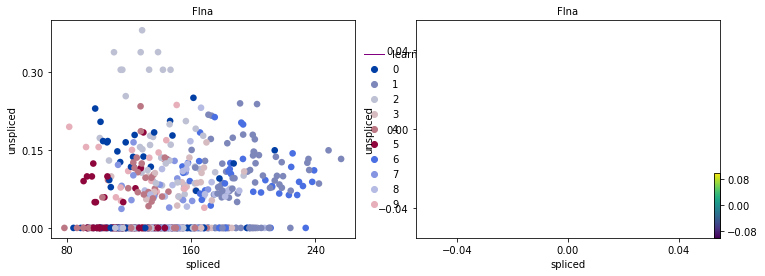

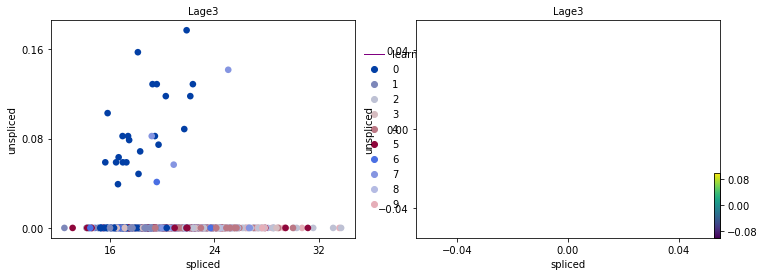

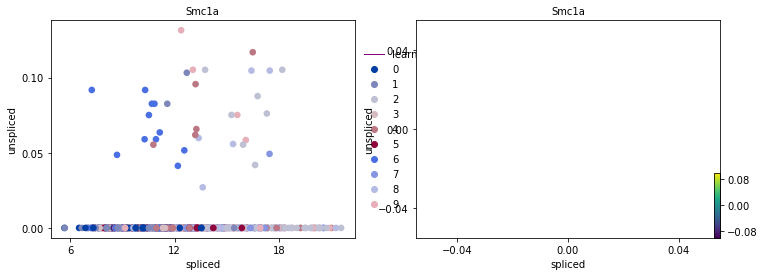

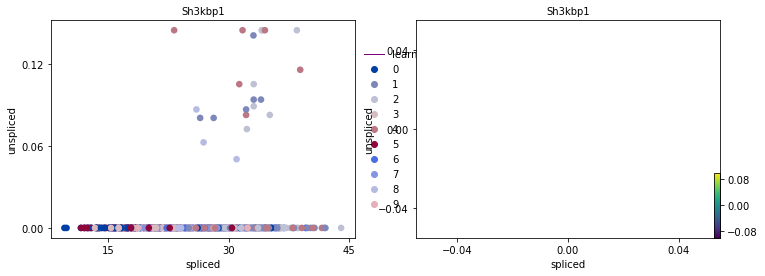

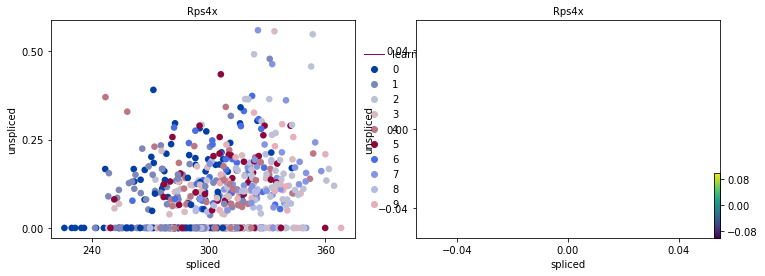

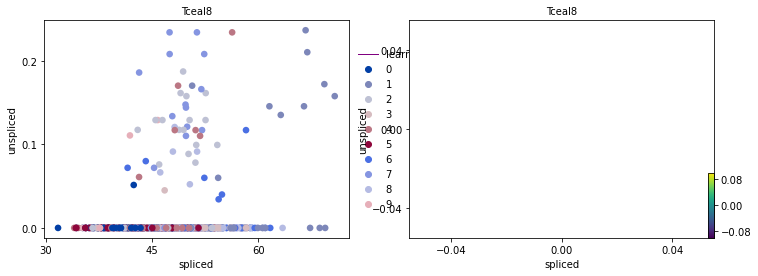

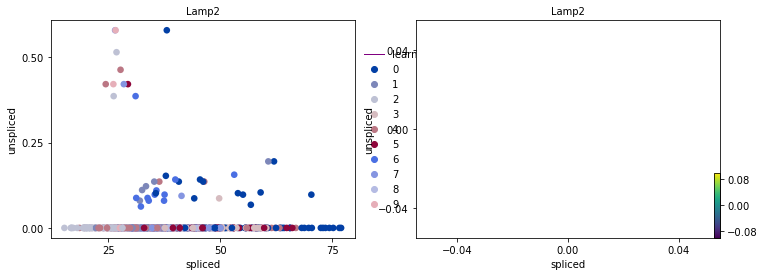

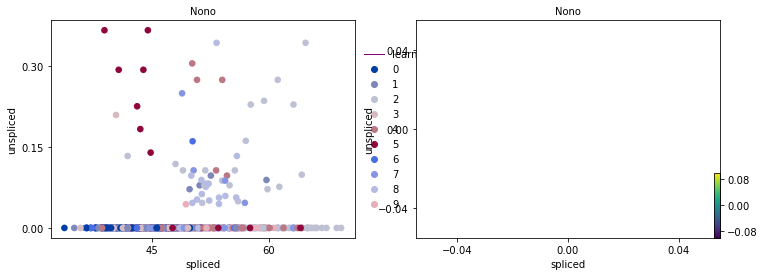

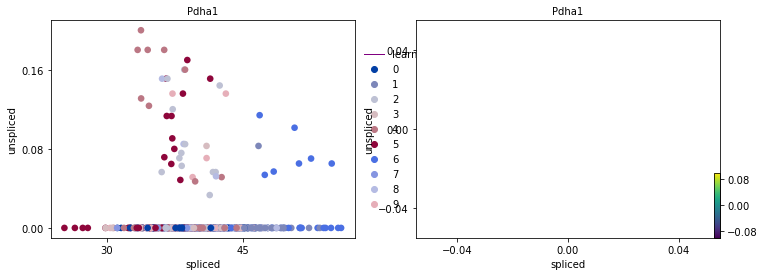

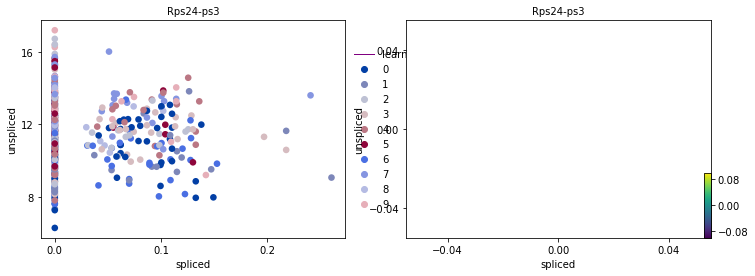

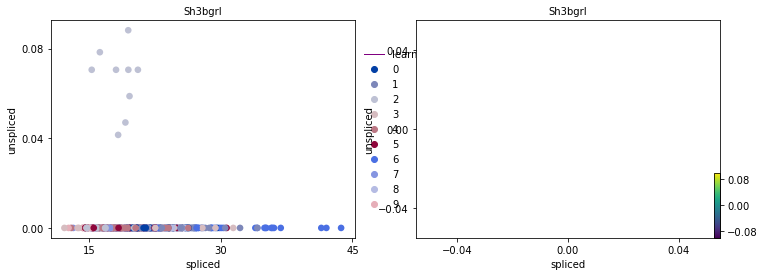

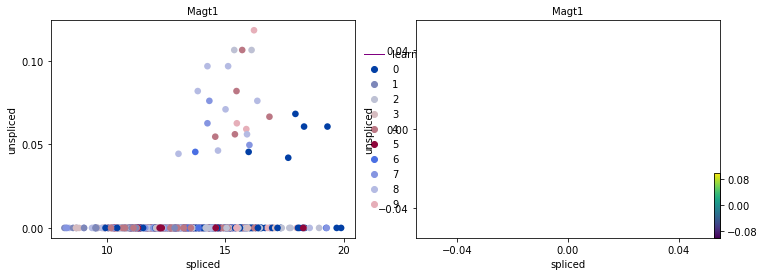

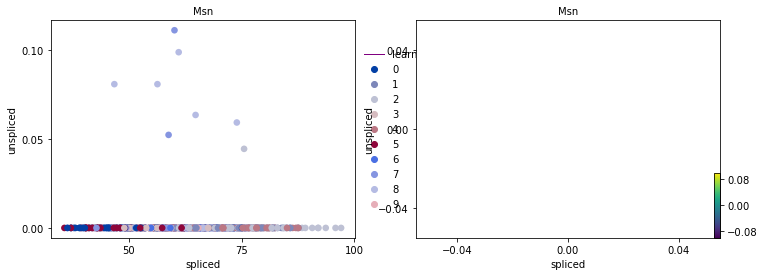

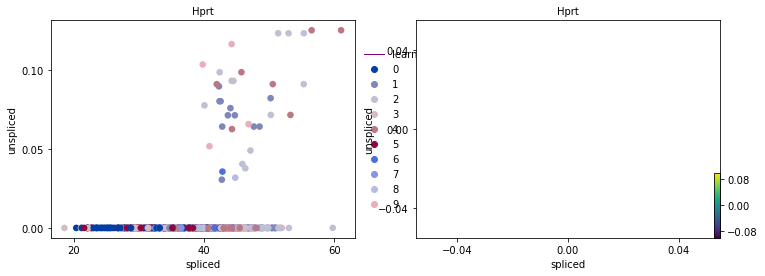

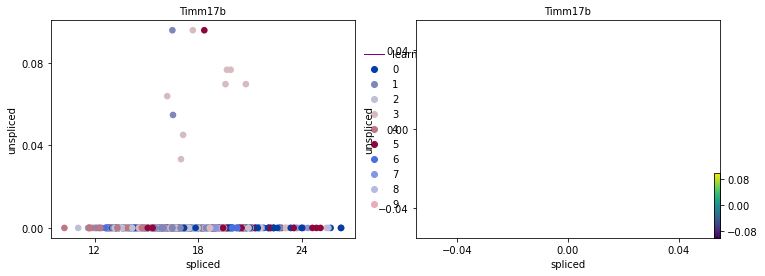

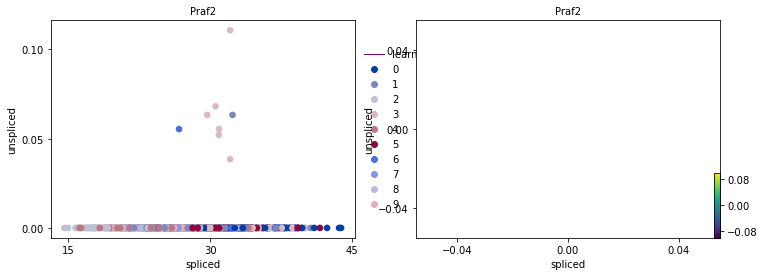

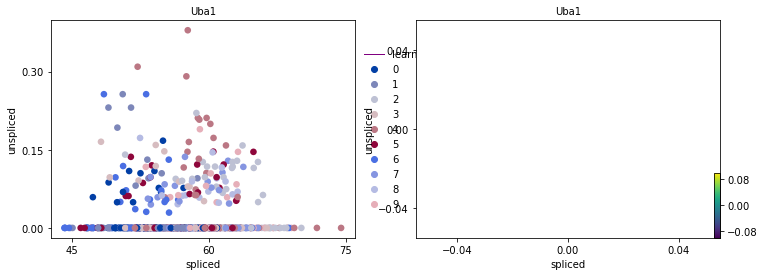

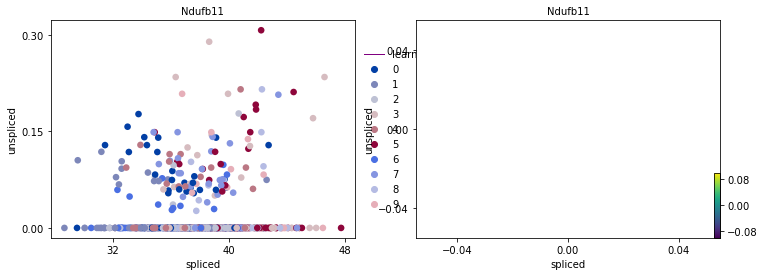

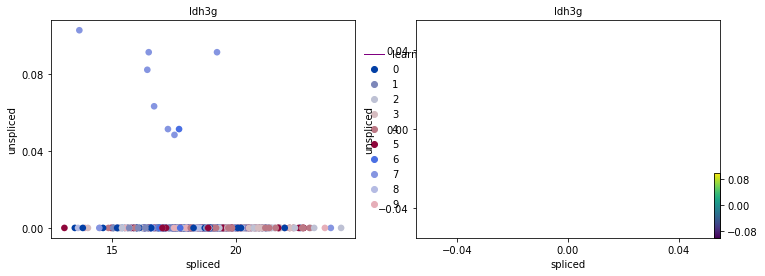

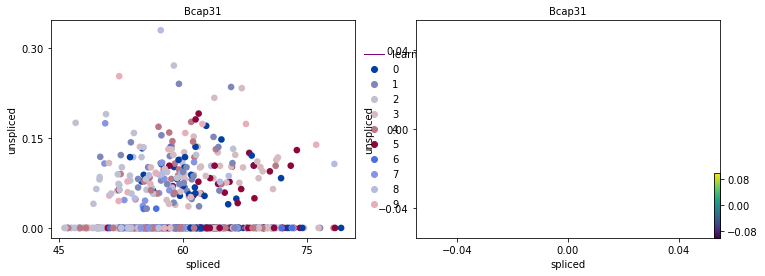

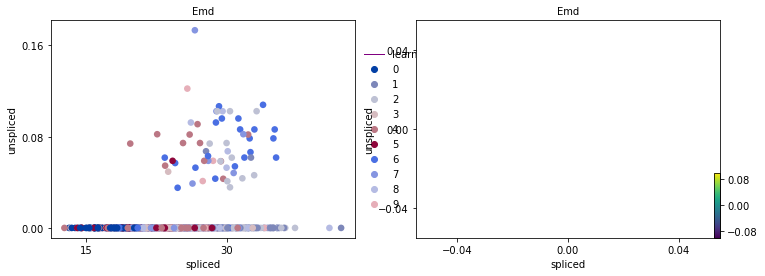

In [46]:
for index, row in df2.iterrows():
    if row.ensembl_id in adata.var.index:
        scv.pl.scatter(adata, row.ensembl_id, title=row.gene_name, color=['clusters', 'velocity'], legend_loc='right margin')